In [1]:
!pip install pennylane-lightning[gpu] 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
df = pd.read_csv("/kaggle/input/pima-indians-diabetes-database/diabetes.csv") 
df.describe()
X = df.drop("Outcome", axis=1).values
y = df["Outcome"].values

In [3]:
import pennylane as qml
import pennylane.numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import accuracy_score

# Load and normalize 25 features
# data = load_breast_cancer()
# X = data.data[:, :25]
# y = data.target

# Split and normalize (L2 norm for amplitude encoding simulation)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = normalize(scaler.fit_transform(X_train), norm='l2')
X_test = normalize(scaler.transform(X_test), norm='l2')

# Data augmentation
X_train_aug = X_train + np.random.normal(0, 0.01, X_train.shape)
X_train = np.vstack([X_train, X_train_aug])
y_train = np.hstack([y_train, y_train])

# Simulated qPCA to reduce to 5D
# This follows the structure inspired by improved QPCA algorithms that use the density matrix
# as the covariance matrix to extract principal components efficiently.
def simulate_qpca(X, num_components=5):
    rho = sum(np.outer(x, x) for x in X) / len(X)  # Density matrix
    eigvals, eigvecs = np.linalg.eigh(rho)
    top_indices = np.argsort(eigvals)[-num_components:]
    top_vectors = eigvecs[:, top_indices]
    return X @ top_vectors

X_train = simulate_qpca(X_train, 5)
X_test = simulate_qpca(X_test, 5)

# Quantum device with 5 wires
dev = qml.device("lightning.qubit", wires=5)

# Variational circuit for 5 qubits
def variational_block(x, weights):
    for i in range(5):
        qml.RY(x[i], wires=i)
        qml.RZ(x[i] ** 2, wires=i)
    for i in range(5):
        qml.RY(weights[i], wires=i)
    for i in range(4):
        qml.CNOT(wires=[i, i + 1])
    qml.CNOT(wires=[4, 0])

@qml.qnode(dev)
def quantum_node(x, weights):
    variational_block(x, weights)
    return [qml.expval(qml.PauliZ(i)) for i in range(5)]

# Hybrid model
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def hybrid_model(x, params):
    q_out = np.array(quantum_node(x, params[:5]), requires_grad=True)
    hidden = leaky_relu(np.dot(params[5:10], q_out) + params[10])
    output = leaky_relu(np.dot(params[11:16], hidden) + params[16])
    final = sigmoid(np.dot(params[17:22], output) + params[22])
    return final

# Weighted BCE
def weighted_bce(preds, labels, pos_weight):
    return -np.mean(pos_weight * labels * np.log(preds + 1e-6) +
                    (1 - labels) * np.log(1 - preds + 1e-6))

# Cost
class_weights = np.array([1.0, len(y_train) / (2 * np.bincount(y_train)[1])])

def cost(params, X, y):
    preds = np.array([hybrid_model(x, params) for x in X], requires_grad=True)
    bce = weighted_bce(preds, y, pos_weight=class_weights[1])
    reg = 0.001 * np.sum(params ** 2)
    return bce + reg

def compute_accuracy(params, X, y):
    preds = [hybrid_model(x, params) > 0.5 for x in X]
    return accuracy_score(y, preds)




/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.4.33 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [4]:
# Training
np.random.seed(42)
total_params = 23  # 5 (quantum) + 5+1 + 5+1 + 5+1
params = np.random.uniform(-0.1, 0.1, total_params, requires_grad=True)

opt = qml.AdamOptimizer(0.01)
epochs = 200
best_acc = 0
best_epo = 0
train_acc_list = []
test_acc_list = []
loss_list = []



In [5]:
for epoch in range(epochs):
    params = opt.step(lambda p: cost(p, X_train, y_train), params)
    loss = cost(params, X_train, y_train)
    train_acc = compute_accuracy(params, X_train, y_train)
    test_acc = compute_accuracy(params, X_test, y_test)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    loss_list.append(loss)
    # print("epoch")
    if test_acc > best_acc:
        best_acc = test_acc
        best_epo = epoch
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch 0 | Loss: 0.7947 | Train Acc: 0.6515 | Test Acc: 0.6494
Epoch 10 | Loss: 0.7897 | Train Acc: 0.6515 | Test Acc: 0.6494
Epoch 20 | Loss: 0.7886 | Train Acc: 0.6515 | Test Acc: 0.6494
Epoch 30 | Loss: 0.7882 | Train Acc: 0.6515 | Test Acc: 0.6494
Epoch 40 | Loss: 0.7883 | Train Acc: 0.6515 | Test Acc: 0.6494
Epoch 50 | Loss: 0.7882 | Train Acc: 0.6515 | Test Acc: 0.6494
Epoch 60 | Loss: 0.7882 | Train Acc: 0.6515 | Test Acc: 0.6494
Epoch 70 | Loss: 0.7882 | Train Acc: 0.6515 | Test Acc: 0.6494
Epoch 80 | Loss: 0.7882 | Train Acc: 0.6515 | Test Acc: 0.6494
Epoch 90 | Loss: 0.7882 | Train Acc: 0.6515 | Test Acc: 0.6494
Epoch 100 | Loss: 0.7882 | Train Acc: 0.6515 | Test Acc: 0.6494
Epoch 110 | Loss: 0.7882 | Train Acc: 0.6515 | Test Acc: 0.6494
Epoch 120 | Loss: 0.7882 | Train Acc: 0.6515 | Test Acc: 0.6494
Epoch 130 | Loss: 0.7882 | Train Acc: 0.6515 | Test Acc: 0.6494
Epoch 140 | Loss: 0.7882 | Train Acc: 0.6515 | Test Acc: 0.6494
Epoch 150 | Loss: 0.7882 | Train Acc: 0.6515 | Test

In [6]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

final_preds = np.array([hybrid_model(x, params) for x in X_test])
pred_labels = (final_preds > 0.5).astype(int)

# Evaluation Metrics
acc = accuracy_score(y_test, pred_labels)
prec = precision_score(y_test, pred_labels)
rec = recall_score(y_test, pred_labels)
f1 = f1_score(y_test, pred_labels)
roc_auc = roc_auc_score(y_test, final_preds)
conf_matrix = confusion_matrix(y_test, pred_labels)

print("Final Evaluation on Test Set:")
print(f"Accuracy     : {acc:.4f}")
print(f"Precision    : {prec:.4f}")
print(f"Recall       : {rec:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"ROC AUC      : {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Final Evaluation on Test Set:
Accuracy     : 0.6494
Precision    : 0.0000
Recall       : 0.0000
F1 Score     : 0.0000
ROC AUC      : 0.6335
Confusion Matrix:
[[100   0]
 [ 54   0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


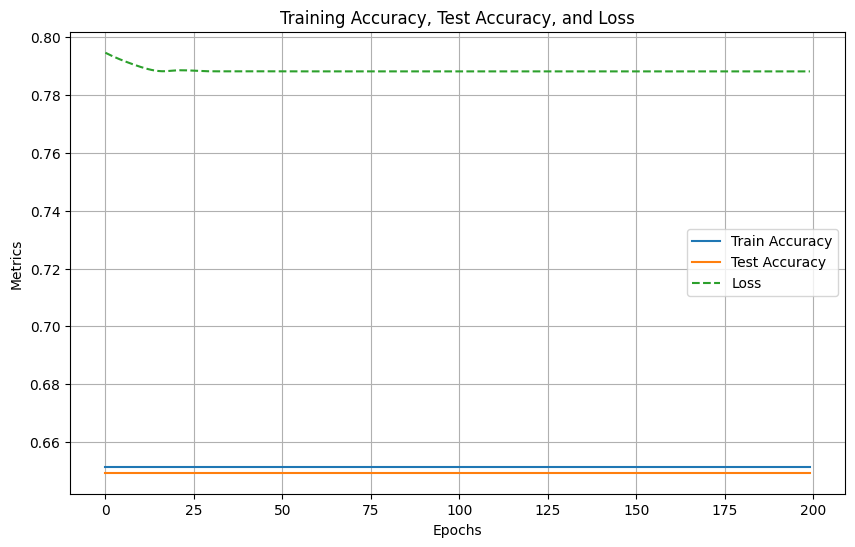

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.plot(loss_list, label='Loss', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.title("Training Accuracy, Test Accuracy, and Loss")
plt.legend()
plt.grid(True)
plt.show()